In [23]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

# Load dataset
dataset = Planetoid(root='dataset', name='Cora')


Processing...
Done!


In [24]:
print(dataset)

Cora()


In [25]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels=16):
#         super().__init__()
#         # torch.manual_seed(42)

#         self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.out = Linear(hidden_channels, dataset.num_classes)


#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index).relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index).relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         return F.softmax(self.out(x), dim=1)
        


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)



In [27]:
for i in dataset:
    print(i)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [28]:
type(dataset)

torch_geometric.datasets.planetoid.Planetoid

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Graph information:
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True

Node features for the first 5 nodes:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

Labels for the first 5 nodes:
tensor([3, 4, 4, 0, 3], device='cuda:0')


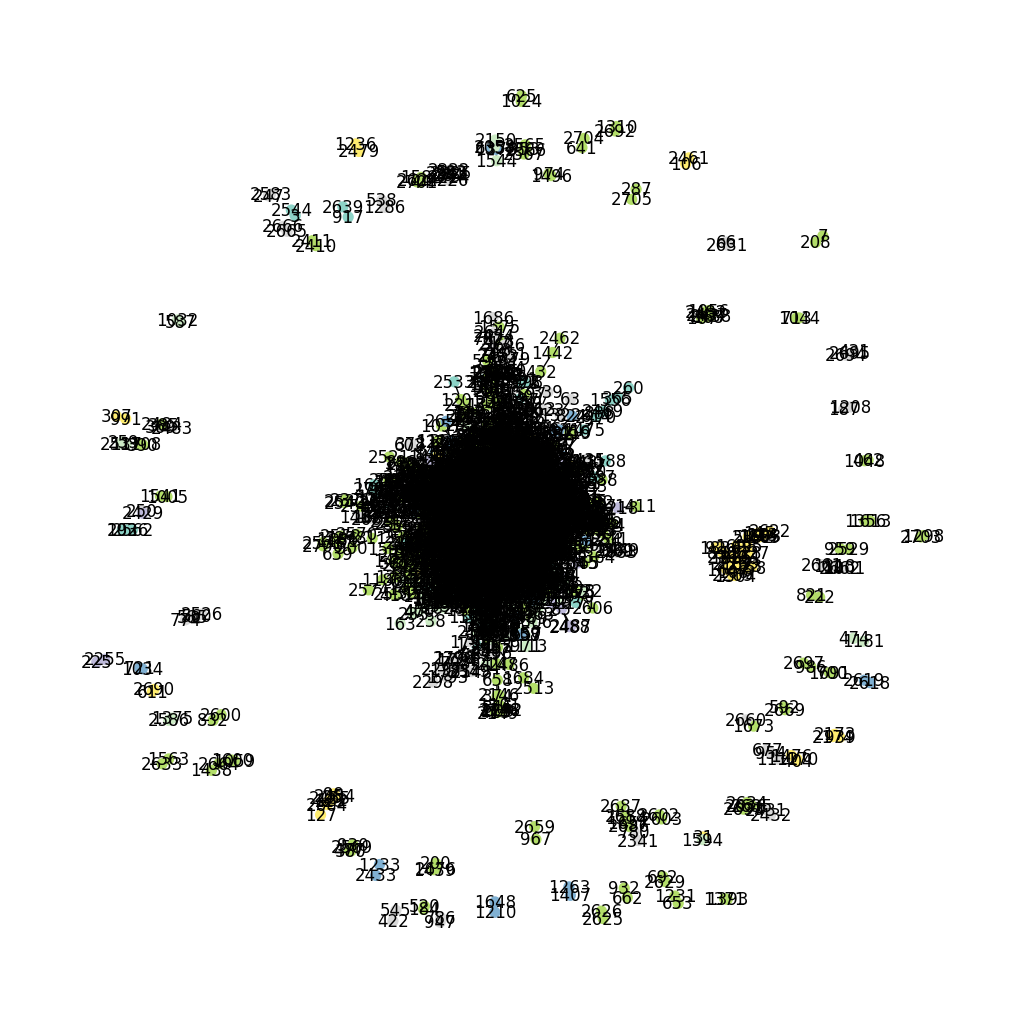

In [29]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Print basic information about the dataset
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph information:')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

# Print node features and labels for the first 5 nodes
print('\nNode features for the first 5 nodes:')
print(data.x[:5])
print('\nLabels for the first 5 nodes:')
print(data.y[:5])

# Visualize the graph
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color=data.y.cpu().numpy(), cmap=plt.get_cmap('Set3'), node_size=50)
plt.show()

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



In [31]:

losses = []
accuracies_test = []
accuracies = []

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())

    correct_test = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc_test = int(correct_test) / int(data.test_mask.sum())
    accuracies_test.append(acc_test)
    accuracies.append(acc)

print(f'Final Accuracy: {acc:.4f}\nFinal Test Accuracy: {acc_test:.4f}')
torch.save(model.state_dict(), 'models/pretrained_gcn.pth')


Final Accuracy: 1.0000
Final Test Accuracy: 0.8060


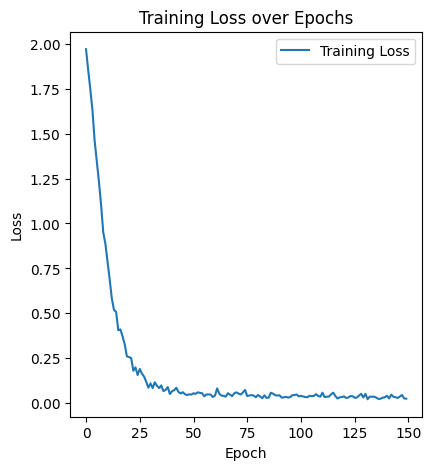

In [32]:
# Plotting loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()



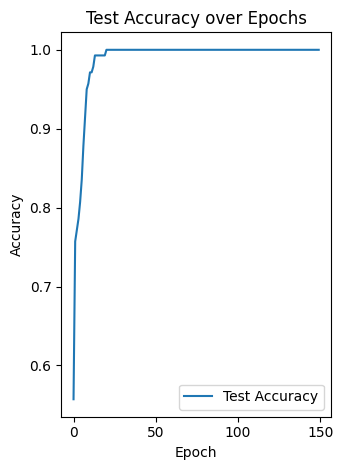

In [33]:
# Plotting accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()